## PRISM Image Reconstruction Analysis Code

<b>Dan Hellfeld</b> <br>
<em>Ph.D. Student</em> | University of California, Berkeley | Department of Nuclear Engineering <br>
<em>Graduate Research Fellow</em> | Nuclear Science and Security Consortium <br>
<a href="mailto:dhellfeld@berkeley.edu">dhellfeld@berkeley.edu</a> | <a href="mailto:dhellfeld@lbl.gov">dhellfeld@lbl.gov</a> | <a href="https://dhellfeld.github.io">dhellfeld.github.io </a>

Updated: July 28, 2016 <br>
 
This code will read in output PRISM Geant4 simulation data and perform histograming, plotting, and MLEM reconstruction algorithms to produce images. This is a developing code, with many more analysis tools coming in the future.

First we will import the desired packages. The most important is the HEALPY package - documentation can be found at https://github.com/healpy/healpy.

In [1]:
%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import pickle as pickle
import healpy as hp
import os.path 

/Users/Hellfeld/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Setting up the data
Now we can read in the output data from the Geant4 simulation

In [14]:
loadfromfile = False   # use either "binary", "text", or False

if (loadfromfile == "binary"):
    dt = np.dtype([('evtN', np.uint32), ('HitNum', np.int8), ('Energy', np.float32), ('DetID', np.uint8), ('DOI', np.uint8),('HPindex', np.uint16)])
    fName = '../../outputs/HP16Ring_DetRing_Response_100k_2152Mask.bin'
    data = np.fromfile(fName, dtype=dt)
    
elif (loadfromfile == "text"):
    # This is very out of date...

    evtN, HitNum, Energy ,DetID, DOI, HPindex = []
    
    fName = '../../outputs/HP16Ring_DetRing_Response_20k_2152Mask.txt'
    a = np.loadtxt(fName, delimiter='\t')
    
    for i in range(0,len(a)):
        evtN.append(a[i][0])
        HitNum.append(a[i][1])
        Energy.append(a[i][2])
        DetID.append(a[i][3])
        DOI.append(a[i][4])
        HPindex.append(a[i][5])
        

*( This method is now deprecated )* 

Now we can create a system response matrix defined as the 2D histogram of the detector ID and HEALPix ID array in the data array. We also create system reponses including Depth of Interaction (DOI) - assumming we have "inner" and "outer" detectors.

In [38]:
NSIDE = 16    # input parameter for HEALPix, n=2,4,8,16,32,...

detbins = 192
HPbins = hp.nside2npix(NSIDE)

if (loadfromfile):
    response          = (np.histogram2d(data['DetID'],data['HPindex'], bins=[detbins,HPbins], range=[[0.5,detbins+0.5],[0.5,HPbins+0.5]]))[0]
    response_inner    = (np.histogram2d(data['DetID'][data['DOI'] <= 10],data['HPindex'][data['DOI'] <= 10], bins=[detbins,HPbins], range=[[0.5,detbins+0.5],[0.5,HPbins+0.5]]))[0]
    response_outer    = (np.histogram2d(data['DetID'][data['DOI'] > 10],data['HPindex'][data['DOI'] > 10], bins=[detbins,HPbins], range=[[0.5,detbins+0.5],[0.5,HPbins+0.5]]))[0]
    response_combined = np.concatenate((response_inner,response_outer))
    
    autocorr          = np.dot(np.transpose(response), response)
    autocorr_inner    = np.dot(np.transpose(response_inner), response_inner)
    autocorr_outer    = np.dot(np.transpose(response_outer), response_outer)
    autocorr_combined = np.dot(np.transpose(response_combined), response_combined)
    
    # if we dont have the response saved, save them
    fName1 = "../../responses/PRISM/HP16_2152Mask_100k_Response.p"
    fName2 = "../../responses/PRISM/HP16_2152Mask_100k_ResponseInner.p"
    fName3 = "../../responses/PRISM/HP16_2152Mask_100k_ResponseOuter.p"
    fName4 = "../../responses/PRISM/HP16_2152Mask_100k_ResponseCombined.p"
    if not os.path.isfile(fName1):
        pickle.dump(response, open(fName1, "wb"))
    if not os.path.isfile(fName2):
        pickle.dump(response_inner, open(fName2, "wb"))
    if not os.path.isfile(fName3):
        pickle.dump(response_outer, open(fName3, "wb"))
    if not os.path.isfile(fName4):
        pickle.dump(response_combined, open(fName4, "wb"))

else:
    fName1 = "../../responses/PRISM/HP16_2152Mask_100k_Response.p"
    fName2 = "../../responses/PRISM/HP16_2152Mask_100k_ResponseInner.p"
    fName3 = "../../responses/PRISM/HP16_2152Mask_100k_ResponseOuter.p"
    fName4 = "../../responses/PRISM/HP16_2152Mask_100k_ResponseCombined.p"
    response = pickle.load(open(fName1, "rb"))
    response_inner = pickle.load(open(fName2, "rb"))
    response_outer = pickle.load(open(fName3, "rb"))
    response_combined = pickle.load(open(fName4, "rb"))

    
    autocorr = np.dot(np.transpose(response), response)
    autocorr_inner = np.dot(np.transpose(response_inner), response_inner)
    autocorr_outer = np.dot(np.transpose(response_outer), response_outer)
    autocorr_combined = np.dot(np.transpose(response_combined), response_combined)



NameError: name 'loadfromfile' is not defined

Moving away from using pickle, because it can be quite slow with large arrays! Instead we just use the numpy save and load functions.

In [39]:
# load in response
#fName = "../../responses/PRISM/HP32_FullMask_1e6_10DOI.npy"
fName = "../../responses/PRISM/HP16_2152Mask_1e6_10DOI_FixedHPangles.npy"
response = np.load(fName)

detbins = np.shape(response)[0]
HPbins = np.shape(response)[1]
NSIDE = int(np.sqrt(HPbins/12))

# if we have DOI, break them up
if detbins == 1920:
    
    # 10 depths
    response_DOI10 = response
    
    # Collapse to 5 depths
    response_DOI5 = np.zeros((192*5,HPbins))

    for i in range(192):
        response_DOI5[(192*0)+i,:] = response[i+192*0,:] + response[i+192*1,:]
        response_DOI5[(192*1)+i,:] = response[i+192*2,:] + response[i+192*3,:]
        response_DOI5[(192*2)+i,:] = response[i+192*4,:] + response[i+192*5,:]
        response_DOI5[(192*3)+i,:] = response[i+192*6,:] + response[i+192*7,:]
        response_DOI5[(192*4)+i,:] = response[i+192*8,:] + response[i+192*9,:]

    # Collapse to 2 depths (I+O)
    response_DOI2 = np.zeros((192*2,HPbins))

    for i in range(192):
        response_DOI2[i,:]     = response[i+192*0,:] + response[i+192*1,:] + response[i+192*2,:] + response[i+192*3,:] + response[i+192*4,:]
        response_DOI2[192+i,:] = response[i+192*5,:] + response[i+192*6,:] + response[i+192*7,:] + response[i+192*8,:] + response[i+192*9,:]


    # Collapse to no DOI
    response_noDOI = np.zeros((192,HPbins))

    for i in range(192):
        response_noDOI[i,:] = response[i,:] + response[i+192*1,:] + response[i+192*2,:] + response[i+192*3,:] + response[i+192*4,:] + response[\
i+192*5,:] + response[i+192*6,:] + response[i+192*7,:] + response[i+192*8,:] + response[i+192*9,:]

            
    autocorr_DOI10 = np.dot(np.transpose(response_DOI10), response_DOI10)
    autocorr_DOI5  = np.dot(np.transpose(response_DOI5),  response_DOI5)
    autocorr_DOI2  = np.dot(np.transpose(response_DOI2),  response_DOI2)
    autocorr_noDOI = np.dot(np.transpose(response_noDOI), response_noDOI)
    

Now we can plot the system matrix

In [69]:
nside = 4

blah = range(12*nside*nside)

angles = hp.pix2ang(nside,blah)

f = open('HEALPix_PhiTheta_Ring.txt', 'w+')

for i in range(12*nside*nside):
    #print hp.pix2ang(16,blah,True)[0][i], hp.pix2ang(16,blah)[1][i]
    f.write(str(angles[0][i]))
    f.write(" ")
    f.write(str(angles[1][i]))
    f.write("\n")
    

<IPython.core.display.Javascript object>


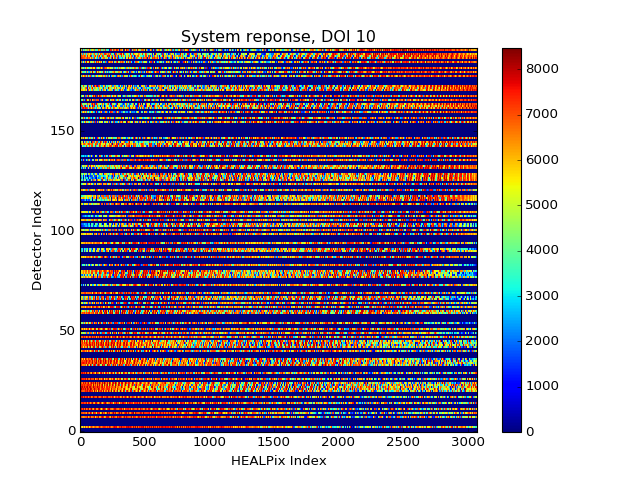

In [31]:
plt.figure()
im = plt.imshow(response_noDOI, cmap=plt.cm.jet, origin="lower", interpolation='nearest', aspect='auto')
plt.colorbar(im)
# plt.clim(0,175)
#plt.xticks(np.arange(0,HPbins+1,2000))
plt.xlabel("HEALPix Index")
#plt.yticks(np.arange(0,detbins+1,120))
plt.ylabel("Detector Index")
plt.title("System reponse, DOI 10")
#plt.clim(0,5)
plt.show()


Sum up the intensities at all angles for each detector. Especially for large DOI bins, we can see the differecne between the outer surface, inner surface and inner layers.

<IPython.core.display.Javascript object>


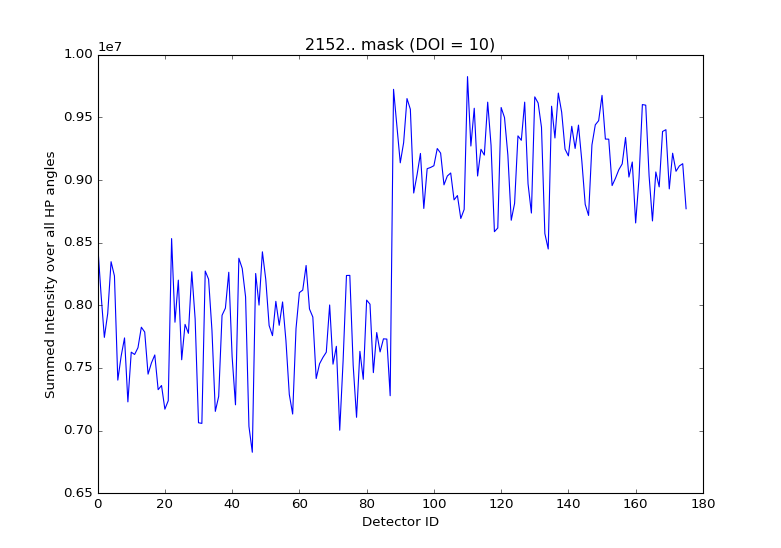

In [12]:
re_ = response_DOI2[~np.all(response_DOI2 == 0, axis=1)]

plt.figure()
plt.plot(re_.sum(axis=1))
plt.xlabel("Detector ID"); plt.ylabel("Summed Intensity over all HP angles"); plt.title("2152.. mask (DOI = 10)")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

And also plot the "autocorrelation" or the transpose of the response times the reponse.

<IPython.core.display.Javascript object>


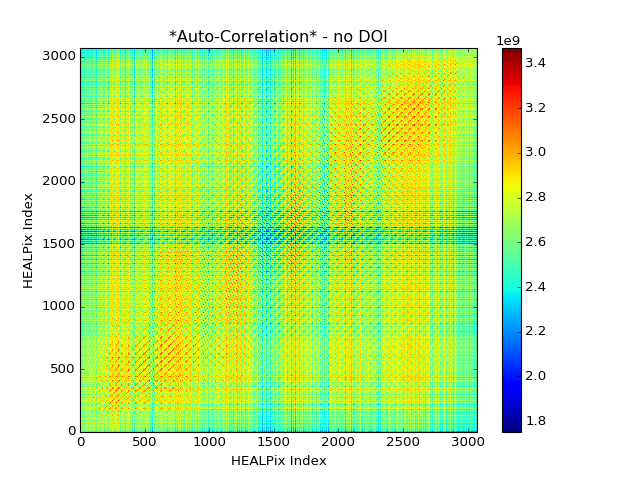

In [23]:
plt.figure()
im = plt.imshow(autocorr_noDOI, cmap=plt.cm.jet, origin='lower', interpolation='nearest', aspect='auto')
plt.colorbar(im)
#plt.clim(0, 4e7)  #adjust to get better contrast
#plt.xticks(np.arange(0,HPbins+1,500))
plt.xlabel("HEALPix Index")
#plt.yticks(np.arange(0,HPbins+1,500))
plt.ylabel("HEALPix Index")
plt.title("*Auto-Correlation* - no DOI")
plt.show()


## Performing Maximum Likelihood Maximization Expectation (MLEM)

We first remove any empty rows from the system matrix (which will be the case for a masked detector). We then pull out a column (or two columns) of the system response to define our signal. We can then define a uniform image to begin with then run MLEM on it with our signal and response functions. 

The MLEM procedure is described by the following (Lange and Carson, 1984):

   $\lambda_j^{n+1} = \frac{\lambda_j^n}{\sum_{i\epsilon J_j}{C_{i,j}}} \sum_{i\epsilon J_j}\frac{C_{i,j}Y_i}{\sum_{k \epsilon I_i}C_{i,k}\lambda_k^n}$

where $\lambda_j^n$ is the image (with $j$ pixels) at iteration $n$, $C_{i,j}$ is the system reponse of detector pixel $i$ from image pixel $j$, and $Y_i$ is the detected signal of detector pixel $i$.

Now what I do is pull out each column of the system matrix and perform MLEM. I then store in the images in the "recon" array. This array represented the image reconstruction from a source at every HEALPix index.

In [40]:
## NO DOI

# initialize the mlem reconstruction matrix
recon_noDOI = np.zeros((HPbins, HPbins))

# Remove all the empty rows from the response matrix (no DOI, inner, or outer)
response_noDOI_ = response_noDOI[~np.all(response_noDOI == 0, axis=1)]

# Loop through all healpix angles
for i in range(0, HPbins):
#for i in range(0, 1):

    # --------------------------------------
    # Pull out signal
    
    # All signals
    signal_noDOI = response_noDOI_[:,i]
    
    # Pull put two source signal
    #q = 1320; p = 1320+10*64
    #signal_noDOI = response_noDOI_[:,q];  signal_noDOI += response_noDOI_[:,p]; signal_noDOI /= np.sum(signal_noDOI)
    
    
    # Ring source
    #signal_noDOI = np.zeros(np.size(response_noDOI_[:,1248]))
    #for i in range(0,64):
    #    signal_noDOI += response_noDOI_[:,(1248+i)]
    #signal_noDOI /= np.sum(signal_noDOI)
    
    # --------------------------------------
    
    # Number of iterations
    itr = 25;

    # Initialize the image to ones
    image_noDOI = np.ones(HPbins)

    # Perform iterations (see Lange and Carson, 1984)
    S_noDOI = np.sum(response_noDOI_, axis=0)  # nice to have this separate, could put directly into image line though...
    for iteration in range(1, itr + 1):
        image_noDOI = (image_noDOI / S_noDOI) * np.dot(signal_noDOI / np.dot(response_noDOI_, image_noDOI), response_noDOI_)
    
    # Normalize images
    image_noDOI = image_noDOI / np.sum(image_noDOI)
                       
    # Push image into the reconstruction matricies
    recon_noDOI[i, :] = image_noDOI
    

In [53]:
## WITH DOI

# initialize the mlem reconstruction matricies
recon_DOI2  = np.zeros((HPbins, HPbins))
recon_DOI5  = np.zeros((HPbins, HPbins))
recon_DOI10 = np.zeros((HPbins, HPbins))

# Remove all the empty rows from the response matrix (no DOI, inner, or outer)
response_DOI2_  = response_DOI2[~np.all(response_DOI2 == 0, axis=1)]
response_DOI5_  = response_DOI5[~np.all(response_DOI5 == 0, axis=1)]
response_DOI10_ = response_DOI10[~np.all(response_DOI10 == 0, axis=1)]


# Loop through all healpix angles
for i in range(0, HPbins):
#for i in range(0, 1):

    # Pull out all signals
    signal_DOI2  = response_DOI2_[:,i]
    signal_DOI5  = response_DOI5_[:,i]
    signal_DOI10 = response_DOI10_[:,i]

    
    # Pull put two source signal
    #q = 1320; p = 1960
    #signal_DOI2 = response_DOI2_[:,q];  signal_DOI2 += response_DOI2_[:,p]; signal_DOI2 /= np.sum(signal_DOI2)
    #signal_DOI5 = response_DOI5_[:,q];  signal_DOI5 += response_DOI5_[:,p]; signal_DOI5 /= np.sum(signal_DOI5)
    #signal_DOI10 = response_DOI10_[:,q];  signal_DOI10 += response_DOI10_[:,p]; signal_DOI10 /= np.sum(signal_DOI10)

    
    # Number of iterations
    itr = 25;

    # Initialize the image to ones
    image_DOI2  = np.ones(HPbins)
    image_DOI5  = np.ones(HPbins)
    image_DOI10 = np.ones(HPbins)


    # Perform iterations (see Lange and Carson, 1984)

    # DOI - 2
    S_DOI2 = np.sum(response_DOI2_, axis=0)
    for iteration in range(1, itr + 1):
        image_DOI2 = (image_DOI2 / S_DOI2) * np.dot(signal_DOI2 / np.dot(response_DOI2_, image_DOI2), response_DOI2_)
        
    # DOI - 5
    S_DOI5 = np.sum(response_DOI5_, axis=0)
    for iteration in range(1, itr + 1):
        image_DOI5 = (image_DOI5 / S_DOI5) * np.dot(signal_DOI5 / np.dot(response_DOI5_, image_DOI5), response_DOI5_)
        
    # DOI - 10
    S_DOI10 = np.sum(response_DOI10_, axis=0)
    for iteration in range(1, itr + 1):
        image_DOI10 = (image_DOI10 / S_DOI10) * np.dot(signal_DOI10 / np.dot(response_DOI10_, image_DOI10), response_DOI10_)
        
        
    # Normalize images
    image_DOI2  = image_DOI2  / np.sum(image_DOI2)
    image_DOI5  = image_DOI5  / np.sum(image_DOI5)
    image_DOI10 = image_DOI10 / np.sum(image_DOI10)
             
        
    # Push image into the reconstruction matricies
    recon_DOI2[i, :]  = image_DOI2
    recon_DOI5[i, :]  = image_DOI5
    recon_DOI10[i, :] = image_DOI10
    

I then plot the images (1D histograms) for every HEALPix angle on one plot.

<IPython.core.display.Javascript object>


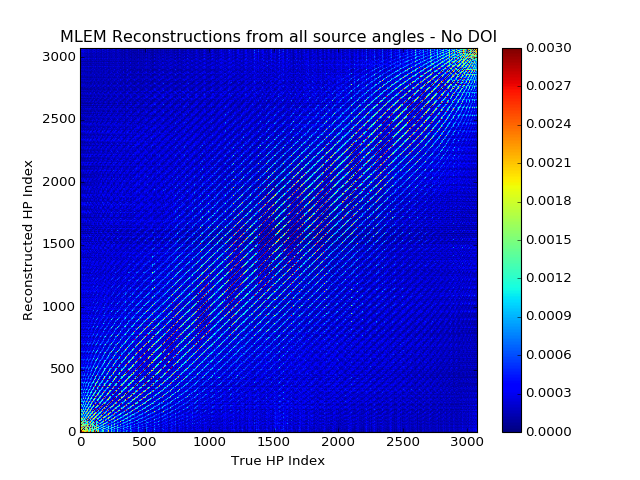

In [50]:
plt.figure()
im2 = plt.imshow(recon_noDOI, cmap=plt.cm.jet, interpolation='nearest', origin="lower", extent=[0.5, HPbins + 0.5, 0.5, HPbins + 0.5], aspect='auto')
plt.colorbar(im2)
plt.clim(0, 0.003)  #adjust to get better contrast
plt.xlabel("True HP Index")
plt.ylabel("Reconstructed HP Index")
plt.title("MLEM Reconstructions from all source angles - No DOI")
plt.show()


I can also plot these images onto the HEALPix map to give us the images on a sphere. I can then add a slider on the plot to interactively change from what HEALPix index the source originated from.

<IPython.core.display.Javascript object>


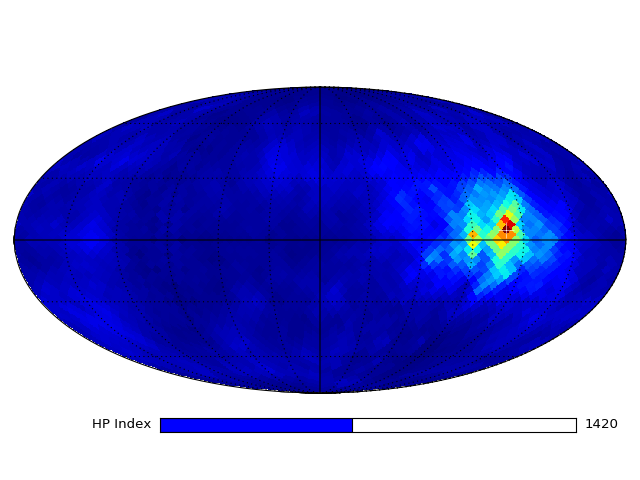

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


0

In [41]:
from matplotlib.widgets import Slider

# choose which images to display
im_ = recon_noDOI
#im_ = recon_DOI5
#im_ = autocorr_noDOI/autocorr_noDOI.sum(axis=0)

hpi = np.arange(0, hp.nside2npix(NSIDE))
plt.figure(4)
hp.mollview(im_[hpi[0],:], fig=4, cbar=False, title="")
hp.projplot(hp.pix2ang(NSIDE,hpi[0]), 'w+', markersize = 15)
hp.graticule()

def update(val):
    hp.mollview(im_[hpi[int(shp.val)],:], fig=4, cbar=False, title="")
    hp.projplot(hp.pix2ang(NSIDE,hpi[int(shp.val)]), 'w+', markersize = 15)
    hp.graticule()
    
axslide = plt.axes([0.25, 0.1, 0.65, 0.03])
shp = Slider(axslide, "HP Index", 0, HPbins, valinit=0, valfmt="%i", dragging=True)
shp.on_changed(update)
    

Or you can just print one of the images. Using the "mollzoom" function, the plot becomes interactive. Also listed are some different types of projections.

<IPython.core.display.Javascript object>


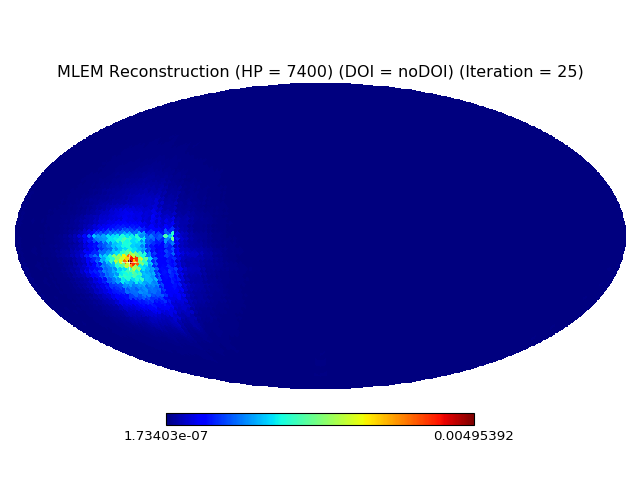

In [112]:
hpi_ = 7400

# Choose option of what to plot
choice = "noDOI"
#choice = "DOI2"
#choice = "DOI5"
#choice = "DOI10"

if choice == "noDOI":
    im_ = recon_noDOI
elif choice == "DOI2":
    im_ = recon_DOI2
elif choice == "DOI5":
    im_ = recon_DOI5
elif choice == "DOI10":
    im_ = recon_DOI5
    
nside = int(np.sqrt(np.shape(im_)[0]/12))

fig=plt.figure(5)
#hp.orthview(im_[hpi_,:], fig=5, title="MLEM Reconstruction")
hp.mollview(im_[hpi_,:], fig=5, title="MLEM Reconstruction (HP = %i) (DOI = %s) (Iteration = %i)" % (hpi_,choice, itr))
#hp.gnomview(im_[hpi_,:], fig=5, title="MLEM Reconstruction")
#hp.cartview(im_[hpi_,:], fig=5, title="MLEM Reconstruction")
#hp.mollzoom(im_[hpi_,:], fig=5, title="MLEM Reconstruction")

# Plot a white cross at the true source location
hp.projplot(hp.pix2ang(nside,hpi_), 'w+', markersize = 15)

# Save plot to file
#fig.savefig('%blah.png')


<IPython.core.display.Javascript object>


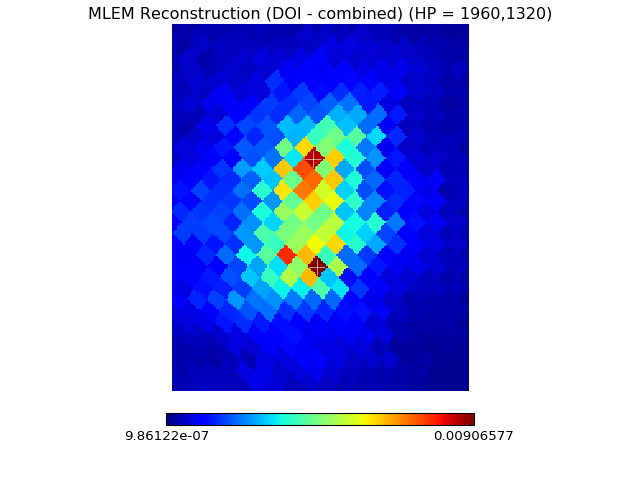

In [21]:
# Plotting procedure when we have two sources

nside = 16

# Choose option
choice = "noDOI"
#choice = "DOI2"
#choice = "DOI5"
#choice = "DOI10"

if choice == "noDOI":
    im_ = image_noDOI
elif choice == "DOI2":
    im_ = image_DOI2
elif choice == "DOI5":
    im_ = image_DOI5
elif choice == "DOI10":
    im_ = image_DOI5

    
plt.figure(12)
hp.mollview(im_, fig=12, title="MLEM Reconstruction (DOI - %s) (HP = %i,%i)" % (choice, p,q))

# Plot a white cross at the true source location
hp.projplot(hp.pix2ang(nside,q), 'w+', markersize = 15)
hp.projplot(hp.pix2ang(nside,p), 'w+', markersize = 15)
plt.show()

We can also plot the sensitivty map onto the sphere

<IPython.core.display.Javascript object>


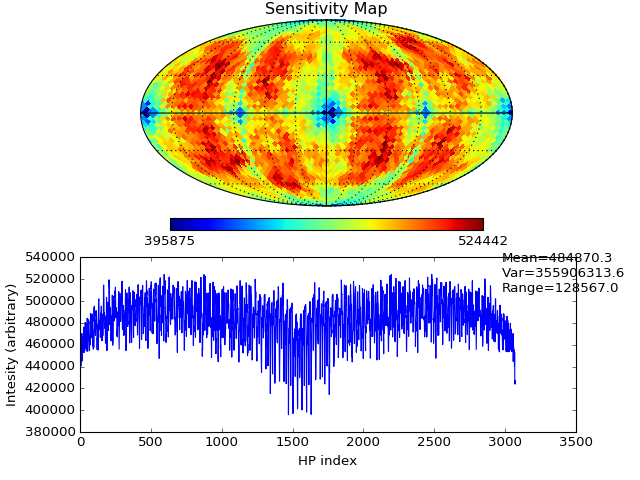

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


In [80]:
# choose which sensitivity to display
Sens = S_noDOI
#Sens = S_DOI2
#Sens = S_DOI5
#Sens = S_DOI10

sens_mean  = Sens.mean()
sens_var   = Sens.var()
sens_range = Sens.ptp()

plt.figure(6)
hp.mollview(Sens, fig=6, cbar=True, title="Sensitivity Map", sub=211)
hp.graticule()

plt.subplot(212)
plt.plot(Sens)
plt.annotate("Mean=%.1f\nVar=%.1f\nRange=%.1f" %(sens_mean,sens_var,sens_range), (.85,.8), xycoords='axes fraction')
plt.xlabel("HP index")
plt.ylabel("Intesity (arbitrary)")
plt.show()

We can also plot the autocorrelation image for a given pixel. We can then correct it with the sensitivity map.

<IPython.core.display.Javascript object>


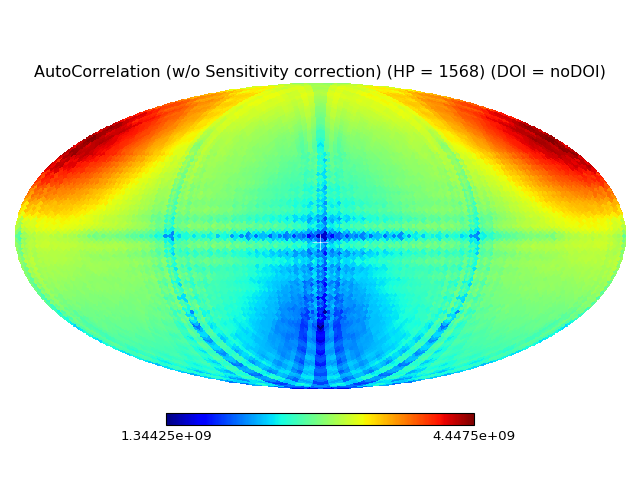

<IPython.core.display.Javascript object>


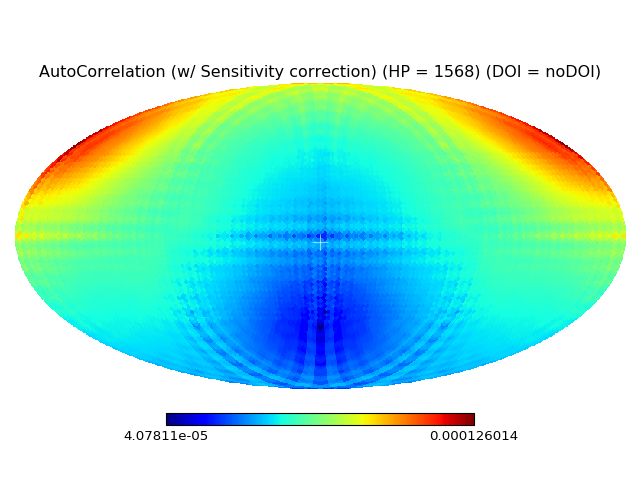

In [113]:
nside = 16
hpi_ = 1568

# Choose option of what to plot
choice = "noDOI"
#choice = "DOI2"
#choice = "DOI5"
#choice = "DOI10"

if choice == "noDOI":
    _autocorr = autocorr_noDOI
    _autocorr_S = autocorr_noDOI/autocorr_noDOI.sum(axis=0)
elif choice == "DOI2":
    _autocorr = autocorr_DOI2
    _autocorr_S = autocorr_DOI2/autocorr_DOI2.sum(axis=0)
elif choice == "DOI5":
    _autocorr = autocorr_DOI5
    _autocorr_S = autocorr_DOI5/autocorr_DOI5.sum(axis=0)
elif choice == "DOI10":
    _autocorr = autocorr_DOI10
    _autocorr_S = autocorr_DOI10/autocorr_DOI10.sum(axis=0)

plt.figure(7)
hp.mollview(_autocorr[hpi_,:],fig=7, title="AutoCorrelation (w/o Sensitivity correction) (HP = %i) (DOI = %s)" % (hpi_, choice))
hp.projplot(hp.pix2ang(nside,hpi_), 'w+', markersize = 15)

plt.figure(8)
hp.mollview(_autocorr_S[hpi_,:],fig=8, title="AutoCorrelation (w/ Sensitivity correction) (HP = %i) (DOI = %s)" % (hpi_, choice))
hp.projplot(hp.pix2ang(nside,hpi_), 'w+', markersize = 15)


Sensitivity correct the autocorrelation matrix we had before.

<IPython.core.display.Javascript object>


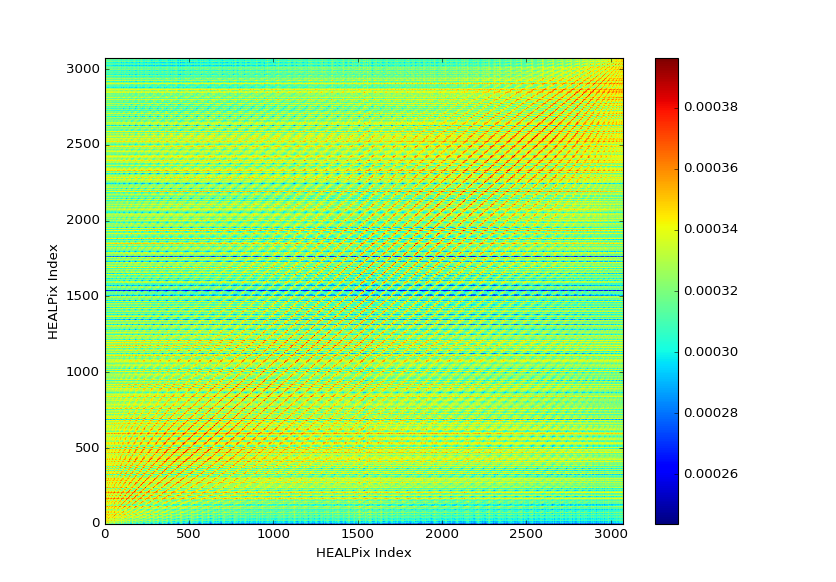

In [92]:
plt.figure()
im = plt.imshow(autocorr_noDOI/autocorr_noDOI.sum(axis=0), cmap=plt.cm.jet, origin='lower', interpolation='nearest', extent=[0.5, HPbins + 0.5, 0.5, HPbins + 0.5], aspect='auto')
plt.colorbar(im)
plt.xticks(np.arange(0,HPbins+1,500))
plt.xlabel("HEALPix Index")
plt.yticks(np.arange(0,HPbins+1,500))
plt.ylabel("HEALPix Index")
plt.show()


Demonstration of how to determine the angular resolution for a given nside in HEALPix

In [7]:
# Healpix resolution
nside = 16
print hp.nside2resol(nside, arcmin=False) * (180./np.pi), "degrees"


1.83225941964 degrees


Plotting a Gaussian on the sphere, also plot the angular power spectrum

Sigma is 900.000000 arcmin (0.261799 rad) 
-> fwhm is 2119.338041 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


<IPython.core.display.Javascript object>


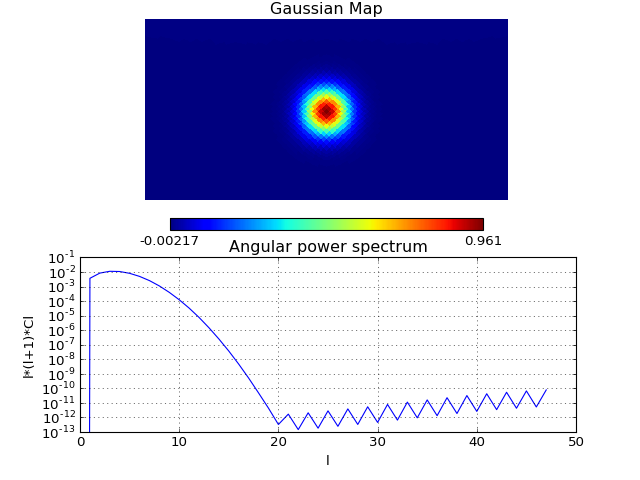

In [11]:
NSIDE = 16

m_sm=np.zeros(hp.nside2npix(NSIDE)) # create map of zeros

_hpi = 1568

m_sm[_hpi] = 100 # setting that index value to 100

gmap=hp.smoothing(m_sm, sigma=np.radians(15.)) # creating a new map with gaussian smearing

plt.figure(13)
hp.cartview(gmap, fig=13, sub=211, title="Gaussian Map")


# Plot the power spectrum of the image
cl_ = hp.anafast(gmap)
l_ = np.arange(len(cl_))
plt.subplot(212)
plt.plot(l_, l_ * (l_+1) * cl_ / (2*np.pi))
plt.yscale('log')
plt.xlabel('l'); plt.ylabel('l*(l+1)*Cl'); plt.grid()
plt.title("Angular power spectrum")
plt.show()


More explicit way to define a gaussian on the sphere

<IPython.core.display.Javascript object>


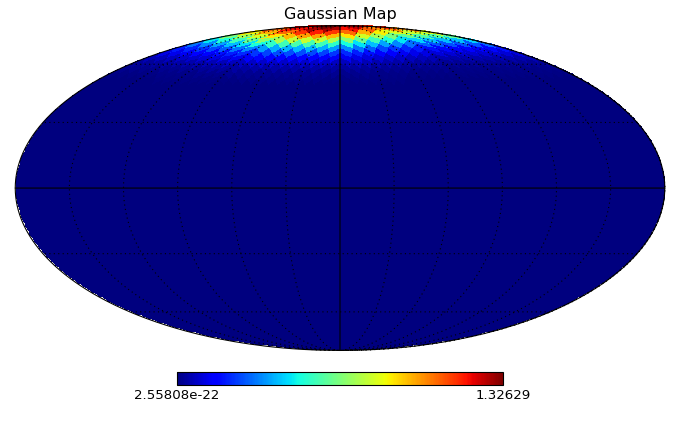

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


In [271]:
# Alternate method (more explicit)

def gauss_HP(nside,theta,phi,sigtheta,sigphi):
    
    # coordinates of centroid (pick a HP index, convert to xyz)
    hpi = hp.ang2pix(nside,phi*np.pi/180.,theta*np.pi/180.)
    
    sigx = np.cos(sigtheta)*np.sin(sigphi)
    sigy = np.sin(sigtheta)*np.sin(sigphi)
    sigz = np.cos(sigphi)
    
    [x0,y0,z0] = hp.pix2vec(nside,hpi)

    [x,y,z] = hp.pix2vec(nside,range(0,hp.nside2npix(nside)))

    return (1/((2*np.pi)**(3/2)*(sigx**2+sigy**2+sigz**2)**(3/2)))*np.exp(-0.5*( ((x-x0)/sigx)**2 + ((y-y0)/sigy)**2 + ((z-z0)/sigz)**2 ))

# width (units?)
sigx = 0.2
sigy = 0.2
sigz = 0.2
sig = 1

# coordinates of centroid (pick a HP index, convert to xyz)
nside = 16
hpi = hp.ang2pix(nside,0.*np.pi/180.,0.*np.pi/180.)

[x0,y0,z0]    = hp.pix2vec(nside,hpi)
[phi0,theta0] = hp.pix2ang(nside,hpi)

# Get all xyz for all points, calculate the gaussian function
[x,y,z]     = hp.pix2vec(nside,range(0,hp.nside2npix(nside)))
[phi,theta] = hp.pix2ang(nside,range(0,hp.nside2npix(nside)))
gaussian = (1/((2*np.pi)**(3/2)*(sigx**2+sigy**2+sigz**2)**(3/2)))*np.exp(-0.5*( ((x-x0)/sigx)**2 + ((y-y0)/sigy)**2 + ((z-z0)/sigz)**2 ))
#gaussian = (1/(2*np.pi*sig**2))*np.exp((((theta-theta0)**2/(-2*sig**2) + (phi-phi0)**2/(-2*sig**2))))



# Plot
hp.mollview(gaussian, title="Gaussian Map")
hp.graticule()
#sphericalheatmap(nside, gaussian) 



<IPython.core.display.Javascript object>


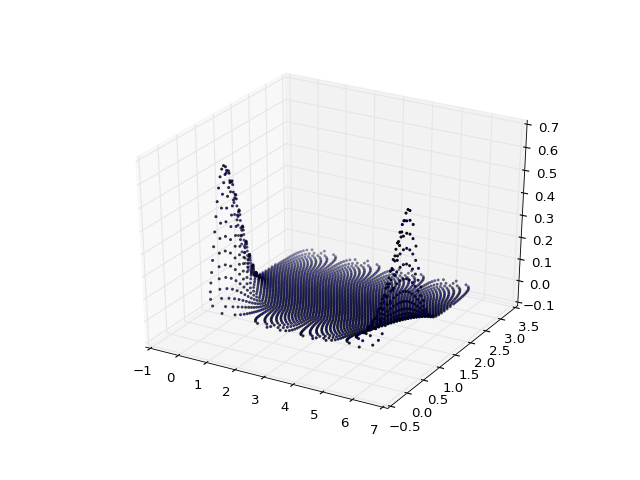

In [136]:
from mpl_toolkits.mplot3d import Axes3D

def RotateY(pos,rad):
    x_ = pos[2]*np.sin(rad)+pos[0]*np.cos(rad)
    y_ = pos[1]
    z_ = pos[2]*np.cos(rad)-pos[0]*np.sin(rad)
    return x_,y_,z_

# Function to rotate vector about Z-axis
def RotateZ(pos,rad):
    x_ = pos[0]*np.cos(rad)-pos[1]*np.sin(rad)
    y_ = pos[0]*np.sin(rad)+pos[1]*np.cos(rad)
    z_ = pos[2]
    return x_,y_,z_

[xx,yy,zz]    = RotateZ([x,y,z], -theta0)
[xxx,yyy,zzz] = RotateY([xx,yy,zz],-phi0)

blah2=hp.vec2pix(nside,x,y,z)
blah = hp.vec2pix(nside,xxx,yyy,zzz)
gaussian_ = np.zeros(hp.nside2npix(nside))
for i in range(len(gaussian_)):
    gaussian_[i] = gaussian[blah[i]]


#__x = 2.*xxx/(1.+zzz)
#__y = 2.*yyy/(1.+zzz)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(theta,phi,gaussian, s=3)

plt.show()



<IPython.core.display.Javascript object>


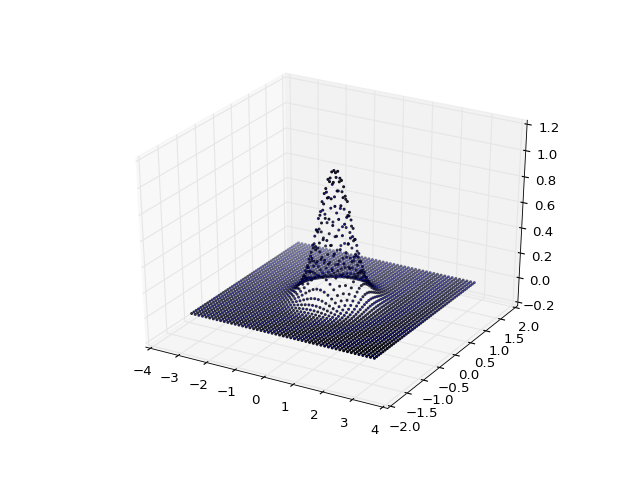

In [8]:
thet = np.linspace(-np.pi,np.pi,50)
ph = np.linspace(-np.pi/2,np.pi/2,50)
[thet1,ph1] = np.meshgrid(thet,ph)
sigthet=0.5
sigph=0.25

blah = np.exp(-0.5*((thet1/sigthet)**2 + (ph1/sigph)**2))

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.scatter(thet1,ph1,blah, s=3)

plt.show()


<IPython.core.display.Javascript object>


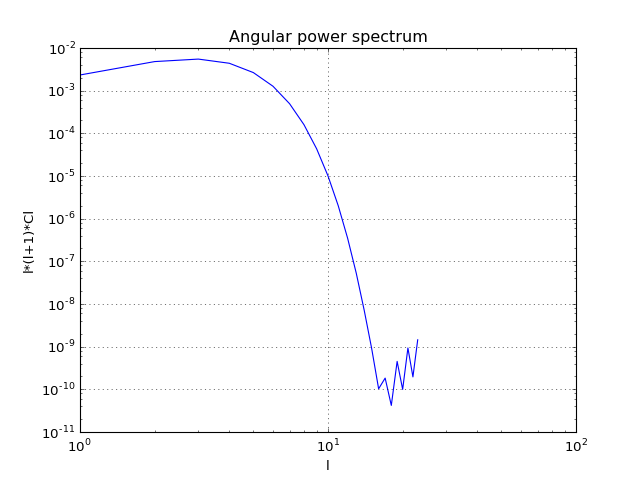

In [194]:
# Plot the power spectrum
plt.figure()
cl_ = hp.anafast(gaussian)
l_  = np.arange(len(cl_))
plt.plot(l_, l_ * (l_+1) * cl_ / (2*np.pi))
plt.yscale('log'); plt.xscale('log')
plt.xlabel('l'); plt.ylabel('l*(l+1)*Cl'); plt.grid()
plt.title("Angular power spectrum")
plt.show()

Run the spherical heat map script

In [11]:
%run SphericalHeatMap.py

In [12]:
# Example use of sphericalheatmap

nside = 16
hpi = 1568

map_ = recon[hpi,:]
#map_ = np.dot(np.transpose(response), response)[hpindex,:]/S
#map_ = S+

sphericalheatmap(nside, map_, hpi)   

Run the spherical histogram script 

In [7]:
%run SphericalHistogram.py

In [ ]:
# Example use of spherical histogram

nside = 16
hpi_ = 1568
image = recon[hpi_,:]

SphericalHistogram(nside,image,hpi_)   # with source line included
#SphericalHistogram(nside,image)        # without the source line

## Imaging Metrics

### Image Resolution

Lets try to fit a 2D gaussian to our images on the sphere...

### Signal to Background

...

### Peak Image to True Source Distance

We can look at the "distance" from the peak image pixel (maximum intensity) to the true source pixel. This gives us an idea of the accuracy of our image. First we can look at the differnce in the HP indicies, but this does not give us a good idea becuase this can be quite large if the true pixel is close but one or two rings away. We then look at the angular distance (in radians) between the max pixel and the true source pixel. This produces a normalized distance metric for the entire sphere.

<IPython.core.display.Javascript object>


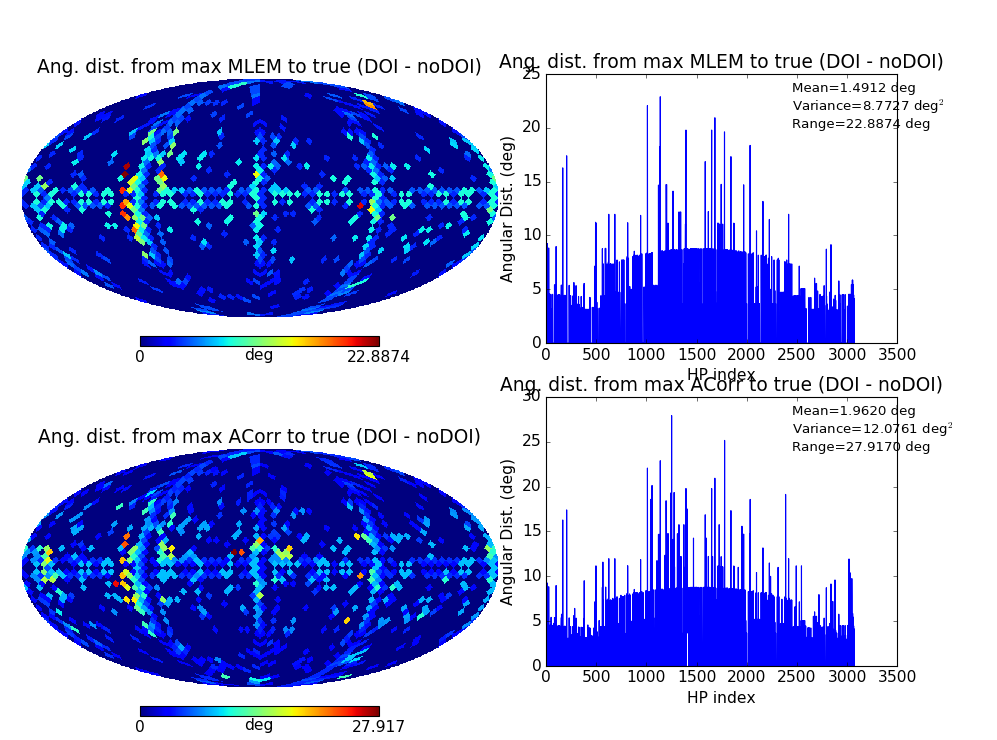

In [95]:
import operator

nside = 16

# Choose option
choice = "noDOI"
#choice = "DOI2"
#choice = "DOI5"
#choice = "DOI10"

if choice == "noDOI":
    _im    = recon_noDOI
    _acorr = autocorr_noDOI
    _S     = S_noDOI
elif choice == "DOI2":
    _im    = recon_DOI2
    _acorr = autocorr_DOI2
    _S     = S_DOI2
elif choice == "DOI5":
    _im    = recon_DOI5
    _acorr = autocorr_DOI5
    _S     = S_DOI5
elif choice == "DOI10":
    _im    = recon_DOI10
    _acorr = autocorr_DOI10
    _S     = S_DOI10


max2true_mlem_angdist  = np.zeros(hp.nside2npix(nside))
max2true_acorr_angdist = np.zeros(hp.nside2npix(nside))

# Loop through all source pixels
for hpi in range(0,hp.nside2npix(nside)):
    
    # peak pixel in mlem image and autocorrelation
    maxindex_mlem  = (max(enumerate(_im[hpi,:]),       key=operator.itemgetter(1)))[0]
    maxindex_acorr = (max(enumerate(_acorr[hpi,:]/_S), key=operator.itemgetter(1)))[0]
    
    # calculate distance metric for mlem case, fill array
    max2true_mlem_angdist[hpi]  = hp.rotator.angdist(hp.pix2ang(nside,maxindex_mlem),hp.pix2ang(nside,hpi))*(180./np.pi)
    
    # calculate distance metric for autocorrelation case, fill array
    max2true_acorr_angdist[hpi] = hp.rotator.angdist(hp.pix2ang(nside,maxindex_acorr),hp.pix2ang(nside,hpi))*(180./np.pi)

    
# Calculate mean, variance, range of the arrays
max2true_mlem_angdist_mean   = max2true_mlem_angdist.mean()
max2true_acorr_angdist_mean  = max2true_acorr_angdist.mean()

max2true_mlem_angdist_var    = max2true_mlem_angdist.var()
max2true_acorr_angdist_var   = max2true_acorr_angdist.var()

max2true_mlem_angdist_range  = max2true_mlem_angdist.ptp()
max2true_acorr_angdist_range = max2true_acorr_angdist.ptp()

# Plot in spherical heat map mode
#sphericalheatmap(nside, max2true_mlem_pix)
#sphericalheatmap(nside, max2true_mlem_angdist)
#sphericalheatmap(nside, max2true_acorr_pix)
#sphericalheatmap(nside, max2true_acorr_angdist)

# Plot in mollview with histograms to the side
plt.figure(11)
hp.mollview(max2true_mlem_angdist,  title="Ang. dist. from max MLEM to true (DOI - %s)" % choice,fig=11,sub=221, unit="deg")
hp.mollview(max2true_acorr_angdist, title="Ang. dist. from max ACorr to true (DOI - %s)" % choice,fig=11,sub=223, unit="deg")

plt.subplot(222)
plt.plot(max2true_mlem_angdist)
plt.xlabel("HP index")
plt.ylabel("Angular Dist. (deg)")
plt.title("Ang. dist. from max MLEM to true (DOI - %s)" % choice)
plt.annotate('Mean=%.4f deg\nVariance=%.4f deg$^2$\nRange=%.4f deg' % (max2true_mlem_angdist_mean,max2true_mlem_angdist_var,max2true_mlem_angdist_range), (0.7, 0.8), xycoords='axes fraction')

plt.subplot(224)
plt.plot(max2true_acorr_angdist)
plt.xlabel("HP index")
plt.ylabel("Angular Dist. (deg)")
plt.title("Ang. dist. from max ACorr to true (DOI - %s)" % choice)
plt.annotate('Mean=%.4f deg\nVariance=%.4f deg$^2$\nRange=%.4f deg' % (max2true_acorr_angdist_mean,max2true_acorr_angdist_var,max2true_acorr_angdist_range), (0.7, 0.8), xycoords='axes fraction')
plt.show()
    

### Sort by distance away instead of HP index

Sort the data for each image based on the distance from the true/peak pixel as opposed to by HP index. If we use the HP index we have get a behavior of having to loop around the entire sphere before we get near the true pixel. If we sort by distance away, we can get a better understanding of how the distribution looks as a function of distance away from the true pixel. Hopefully this can help to quantify artifacts far away from the true pixel and come up with some weighting scheme.

In [96]:
nside = 16

hpi_ = range(hp.nside2npix(nside))

ordered = np.zeros((hp.nside2npix(nside),hp.nside2npix(nside)))
distmap = np.zeros((hp.nside2npix(nside),hp.nside2npix(nside)))
for i in range(0,hp.nside2npix(nside)):
    ordered[i,:] = range(hp.nside2npix(nside))

dists = np.zeros((hp.nside2npix(nside),hp.nside2npix(nside)))

for i in range(0,hp.nside2npix(nside)):
    dists[i,:] = hp.rotator.angdist(hp.pix2ang(nside,i), hp.pix2ang(nside,hpi_))
    distmap[i,:] = [x for (y,x) in sorted(zip(dists[i,:],ordered[i,:]))]

distmap = distmap.astype(int)

<IPython.core.display.Javascript object>


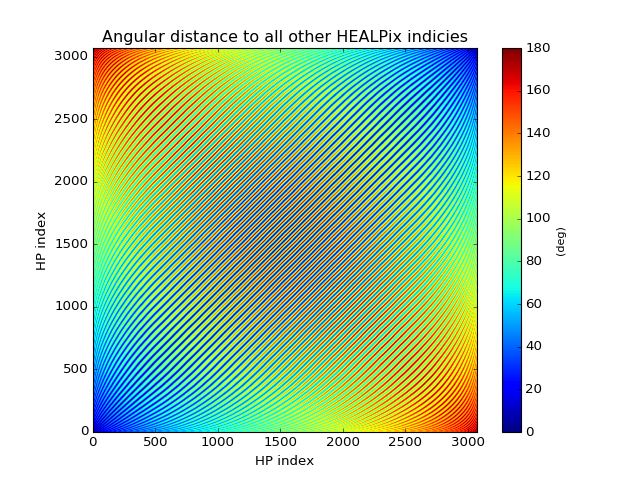

<IPython.core.display.Javascript object>


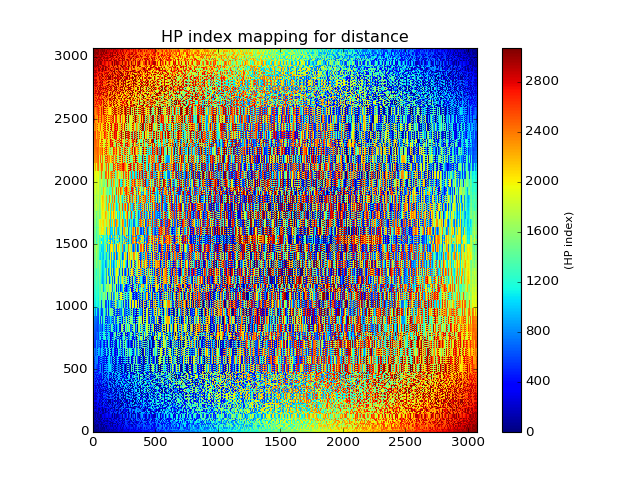

In [8]:
# plot the distances
plt.figure()
aa = plt.imshow(dists*180./np.pi, origin="lower", interpolation="nearest")
cbar = plt.colorbar(aa)
cbar.set_label('(deg)',size=10)
plt.title("Angular distance to all other HEALPix indicies")
plt.xlabel("HP index"); plt.ylabel("HP index")

# # plot the sorted distances (boring...)
#plt.figure()
#aa = plt.imshow(np.sort(dists,axis=1), origin="lower", interpolation="nearest")
#plt.colorbar(aa)
#plt.title("Angular distance to all other HEALPix indicies (sorted)")
#plt.ylabel("HP index")

# plot the hp index mapping   
plt.figure()
aa = plt.imshow(distmap, origin="lower", interpolation="nearest")
cbar = plt.colorbar(aa)
cbar.set_label('(HP index)',size=10)
plt.title("HP index mapping for distance")


### Distance histogram

For a given angular distance, there may be many healpix points (think of rings). So is we ever sample using the angular distance, we will have to introduce some weighting to correct for this. We can histogram the distances for a given healpix pixel to get an idea of how many times we get a certain distance. We can then use this to correct for oversampling from a certain distance.

<IPython.core.display.Javascript object>


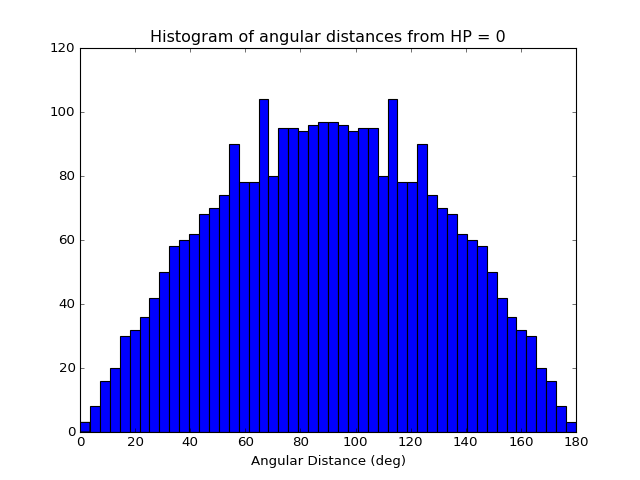

In [198]:
# Histogram the distances for a given hp index
## can we use this to define some sort of distance weighting?

hpi_ = 0

plt.figure()
plt.hist(dists[hpi_]*180/np.pi,bins=50,range=(0,180))
plt.xlabel("Angular Distance (deg)")
plt.title("Histogram of angular distances from HP = %i" % hpi_)
plt.show()

### Sorted Distance curve

For any healpix pixel we will have a mapping between every healpix pixel and its angular distance from the pixel of interest. We can sort the healpix pixels according to distance to get an idea of what the distance distribution looks like as we move away from the pixel of interest.

<IPython.core.display.Javascript object>


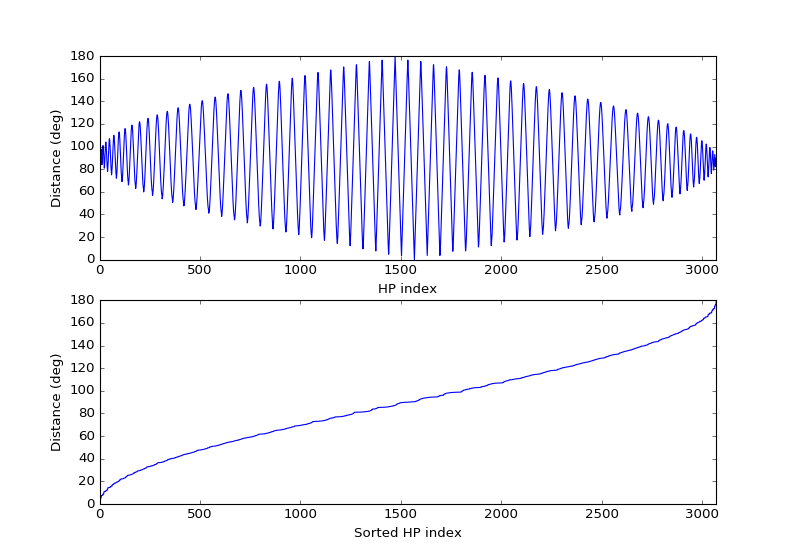

In [212]:
nside = 16
hpi_ = 1568

plt.figure()
plt.subplot(211)
plt.plot(dists[hpi_]*180./np.pi)
plt.xlabel("HP index"); plt.ylabel("Distance (deg)")
plt.xlim(0,hp.nside2npix(nside))
plt.subplot(212)
plt.plot((np.sort(dists,axis=1))[hpi_]*180./np.pi)
plt.xlabel("Sorted HP index"); plt.ylabel("Distance (deg)")
plt.xlim(0,hp.nside2npix(nside))
plt.show()

#### Sorted MLEM and AutoCorr images

In [97]:
sorted_mlem     = np.zeros((3072,3072))
sorted_acorr = np.zeros((3072,3072))

# Choose option
choice = "noDOI"
#choice = "DOI2"
#choice = "DOI5"
#choice = "DOI10"

if choice == "noDOI":
    _im    = recon_noDOI
    acorr_senscor = autocorr_noDOI/autocorr_noDOI.sum(axis=0)
elif choice == "DOI2":
    _im    = recon_DOI2
    acorr_senscor = autocorr_DOI2/autocorr_DOI2.sum(axis=0)
elif choice == "DOI5":
    _im    = recon_DOI5
    acorr_senscor = autocorr_DOI5/autocorr_DOI5.sum(axis=0)
elif choice == "DOI10":
    _im    = recon_DOI10
    acorr_senscor = autocorr_DOI10/autocorr_DOI10.sum(axis=0)
    

for i in range(0,3072):
    sorted_mlem[i,:]  = _im[i,distmap[i,:]]
    sorted_acorr[i,:] = acorr_senscor[i,distmap[i,:]]


Plot them

<IPython.core.display.Javascript object>


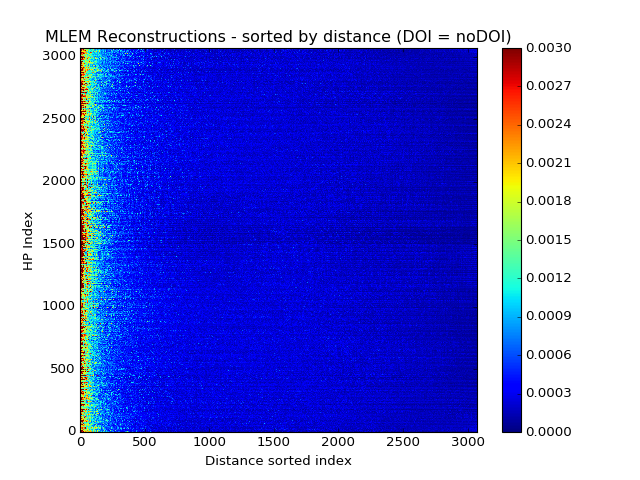

<IPython.core.display.Javascript object>


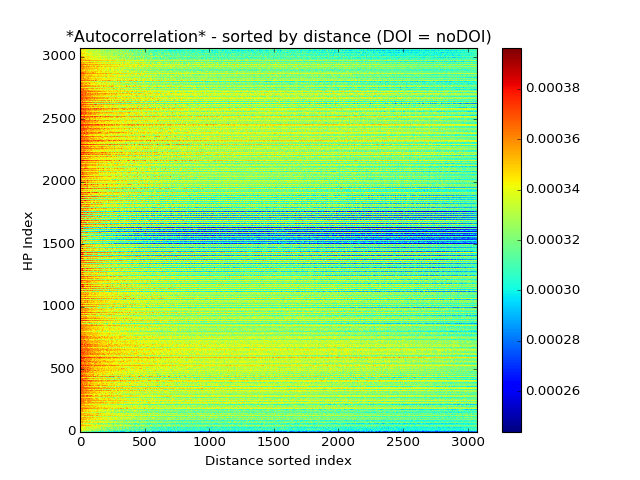

In [98]:
plt.figure()
aa = plt.imshow(sorted_mlem, origin="lower", interpolation="nearest", aspect="auto")
plt.colorbar(aa)
plt.title("MLEM Reconstructions - sorted by distance (DOI = %s)" %choice)
plt.ylabel("HP Index"); plt.xlabel("Distance sorted index")
plt.clim(0, 0.003)  #adjust to get better contrast

plt.figure()
aa = plt.imshow(sorted_acorr, origin="lower", interpolation="nearest", aspect="auto")
plt.colorbar(aa)
plt.title("*Autocorrelation* - sorted by distance (DOI = %s)" %choice)
plt.ylabel("HP Index"); plt.xlabel("Distance sorted index")

plt.show()

Lets just look at one image, sorted by distance. We can also convert the HP indicies to distances.

<IPython.core.display.Javascript object>


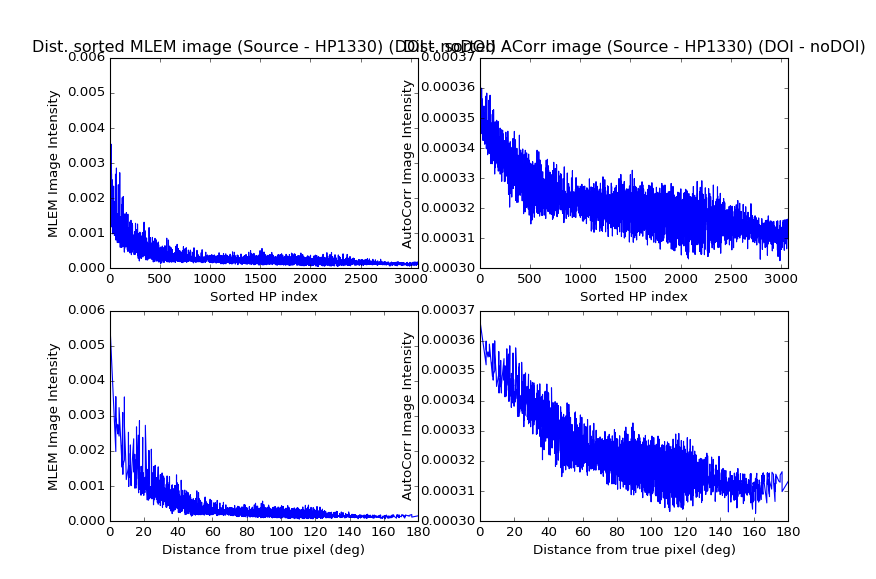

In [99]:
hpi_ = 1330

plt.figure()
plt.subplot(221)
plt.plot(sorted_mlem[hpi_])
plt.xlabel("Sorted HP index"); plt.ylabel("MLEM Image Intensity")
#plt.yscale('log')
plt.xlim(0,hp.nside2npix(nside))
plt.title("Dist. sorted MLEM image (Source - HP%i) (DOI - %s)" % (hpi_, choice))
plt.subplot(223)
plt.plot((np.sort(dists,axis=1))[hpi_]*180./np.pi, sorted_mlem[hpi_])
plt.xlabel("Distance from true pixel (deg)"); plt.ylabel("MLEM Image Intensity")
#plt.yscale('log')

plt.subplot(222)
plt.plot(sorted_acorr[hpi_])
plt.xlabel("Sorted HP index"); plt.ylabel("AutoCorr Image Intensity")
#plt.yscale('log')
plt.xlim(0,hp.nside2npix(nside))
plt.title("Dist. sorted ACorr image (Source - HP%i) (DOI - %s)" % (hpi_, choice))
plt.subplot(224)
plt.plot((np.sort(dists,axis=1))[hpi_]*180./np.pi, sorted_acorr[hpi_])
plt.xlabel("Distance from true pixel (deg)"); plt.ylabel("AutoCorr Image Intensity")
#plt.yscale('log')

plt.show()

    


Take the mean MLEM image intensity for each distance sorted HP index to get the overal behavior for the system. We can then use this to look at the deviations from this for each image pixel.

<IPython.core.display.Javascript object>


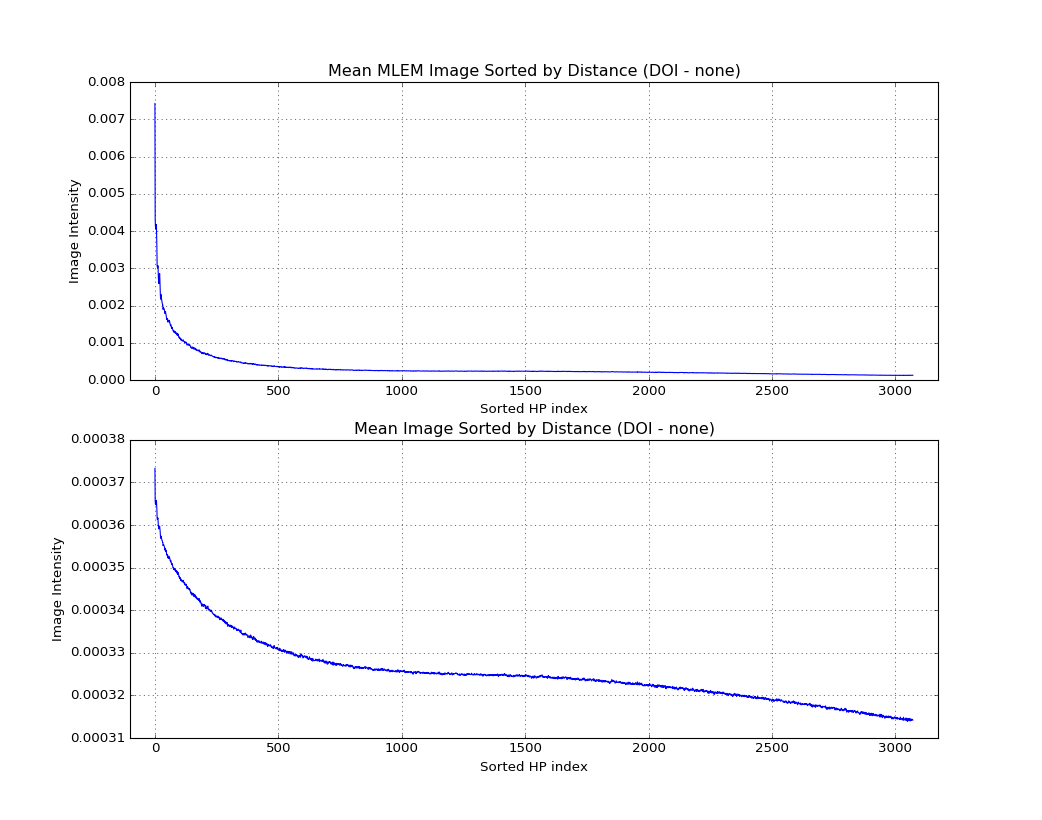

In [25]:
mean_sorted_mlem  = sorted_mlem.mean(axis=0)
mean_sorted_acorr = sorted_acorr.mean(axis=0)

plt.figure()
plt.subplot(211)
plt.plot(mean_sorted_mlem)
#plt.plot(mean_sorted_mlem1, label="MLEM, no DOI"); plt.plot(mean_sorted_mlem2, label="MLEM, DOI (I+O)"); plt.legend(loc='upper right')
#plt.yscale('log')
plt.xlim(-100,3172)
plt.grid(which="both")
plt.title("Mean MLEM Image Sorted by Distance (DOI - %s)" %choice)
plt.xlabel("Sorted HP index"); plt.ylabel("Image Intensity")
plt.subplot(212)
plt.plot(mean_sorted_acorr)
#plt.plot(mean_sorted_acorr1, label="ACorr, no DOI"); plt.plot(mean_sorted_acorr2, label="ACorr, DOI (I+O)"); plt.legend(loc='upper right')
#plt.yscale('log')
plt.xlim(-100,3172)
plt.grid(which="both")
plt.title("Mean Image Sorted by Distance (DOI - %s)" %choice)
plt.xlabel("Sorted HP index"); plt.ylabel("Image Intensity")
plt.show()


Look at the deviations from the mean for a given source location

<IPython.core.display.Javascript object>


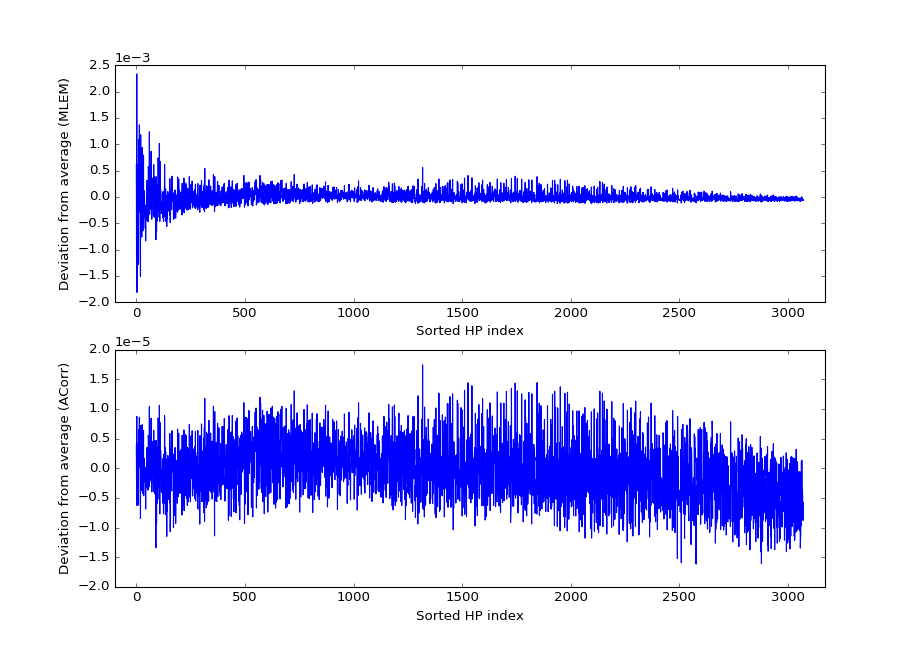

In [26]:
resid_sorted_mlem  = sorted_mlem  - mean_sorted_mlem
resid_sorted_acorr = sorted_acorr - mean_sorted_acorr


# plot for a given source index
hpi_ = 1320

plt.figure()
plt.subplot(211)
plt.plot(resid_sorted_mlem[hpi_])
plt.ylabel("Deviation from average (MLEM)"); plt.xlabel("Sorted HP index")
plt.xlim(-100,3172)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.subplot(212)
plt.plot(resid_sorted_acorr[hpi_])
plt.ylabel("Deviation from average (ACorr)"); plt.xlabel("Sorted HP index")
plt.xlim(-100,3172)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()



Mean square error

<IPython.core.display.Javascript object>


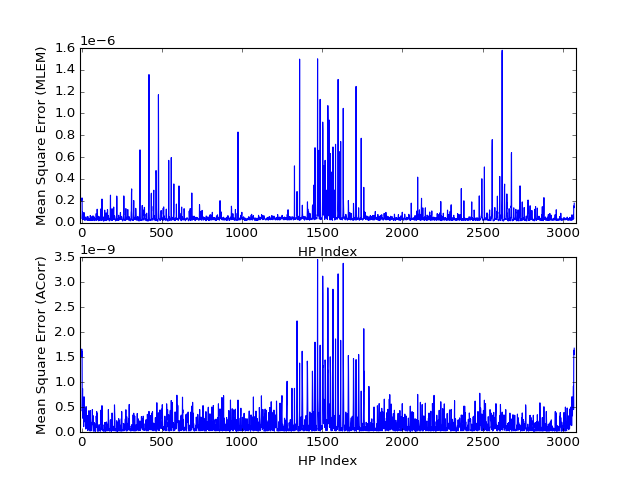

<IPython.core.display.Javascript object>


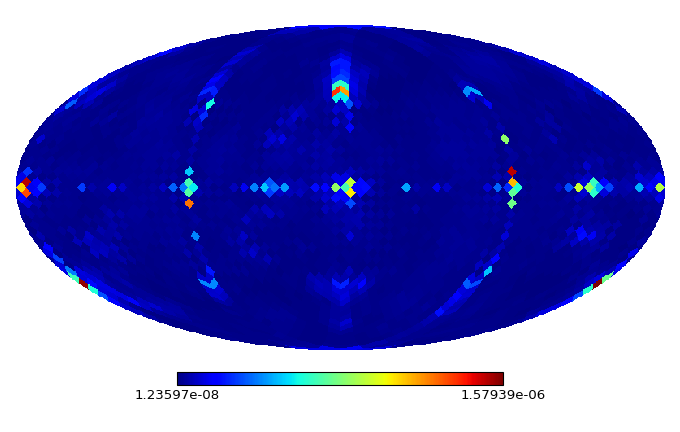

<IPython.core.display.Javascript object>


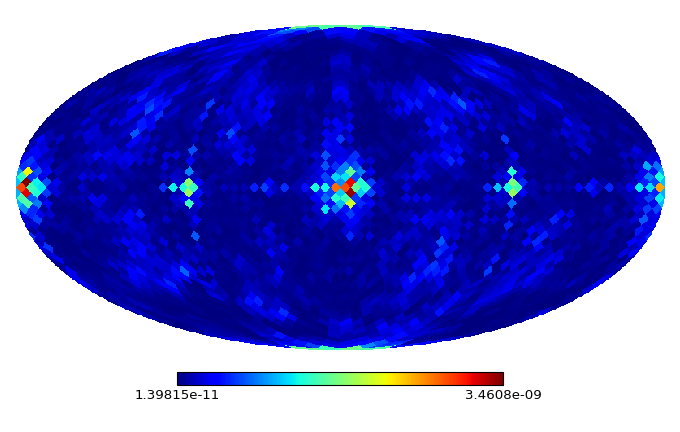

In [28]:
MSE_sorted_mlem  = ((resid_sorted_mlem**2).sum(axis=1))/len(resid_sorted_mlem)
MSE_sorted_acorr = ((resid_sorted_acorr**2).sum(axis=1))/len(resid_sorted_acorr)


plt.figure()
plt.subplot(211)
plt.plot(MSE_sorted_mlem)
plt.xlabel("HP Index"); plt.ylabel("Mean Square Error (MLEM)")
plt.xlim(-10,3082)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.subplot(212)
plt.plot(MSE_sorted_acorr)
plt.xlabel("HP Index"); plt.ylabel("Mean Square Error (ACorr)")
plt.xlim(-10,3082)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

# in mollview
hp.mollview(MSE_sorted_mlem, title="")
hp.mollview(MSE_sorted_acorr, title="")


### Bias and Variance map for MLEM and AutoCorr

In [42]:
def norm((x,y,z)):
    return np.sqrt(x**2 + y**2 + z**2)
    
def renorm2one((x,y,z)):
    scaler = 1./norm((x,y,z))
    return scaler*x,scaler*y,scaler*z


# Choose option
choice = "noDOI"
#choice = "DOI2"
#choice = "DOI5"
#choice = "DOI10"

if choice == "noDOI":
    _im    = recon_noDOI
    acorr_senscor = autocorr_noDOI/autocorr_noDOI.sum(axis=0)
elif choice == "DOI2":
    _im    = recon_DOI2
    acorr_senscor = autocorr_DOI2/autocorr_DOI2.sum(axis=0)
elif choice == "DOI5":
    _im    = recon_DOI5
    acorr_senscor = autocorr_DOI5/autocorr_DOI5.sum(axis=0)
elif choice == "DOI10":
    _im    = recon_DOI10
    acorr_senscor = autocorr_DOI10/autocorr_DOI10.sum(axis=0)

    
nside = int(np.sqrt(np.shape(_im)[0]/12))

[x,y,z] = hp.pix2vec(nside,range(12*nside*nside))

mean_pos_mlem  = np.zeros((12*nside*nside,3))
mean_pos_acorr = np.zeros((12*nside*nside,3))

var_pos_mlem  = np.zeros((12*nside*nside,3))
var_pos_acorr = np.zeros((12*nside*nside,3))
var_mlem      = np.zeros(12*nside*nside)
var_acorr     = np.zeros(12*nside*nside)

std_mlem      = np.zeros(12*nside*nside)
std_acorr     = np.zeros(12*nside*nside)

for i in range(0,12*nside*nside):
    mean_pos_mlem[i,:]  = (np.dot(x,_im[i,:]),np.dot(y,_im[i,:]),np.dot(z,_im[i,:]))
    mean_pos_acorr[i,:] = (np.dot(x,acorr_senscor[i,:]),np.dot(y,acorr_senscor[i,:]),np.dot(z,acorr_senscor[i,:]))
    
    var_pos_mlem[i,:]  = [np.dot((x - mean_pos_mlem[i,0])**2 ,_im[i,:])          ,np.dot((y - mean_pos_mlem[i,1])**2,_im[i,:])           ,np.dot((z - mean_pos_mlem[i,2])**2,_im[i,:])]
    var_pos_acorr[i,:] = [np.dot((x - mean_pos_acorr[i,0])**2,acorr_senscor[i,:]),np.dot((y - mean_pos_acorr[i,1])**2,acorr_senscor[i,:]),np.dot((z - mean_pos_acorr[i,2])**2,acorr_senscor[i,:])]

    var_mlem[i]  = var_pos_mlem[i,:].sum()
    var_acorr[i] = var_pos_acorr[i,:].sum()
    
    std_mlem[i]  = np.sqrt(var_mlem[i])
    std_acorr[i] = np.sqrt(var_acorr[i])
    
    #renorm the mean positions to be on the sphere
    mean_pos_mlem[i,:]  = renorm2one(mean_pos_mlem[i,:])
    mean_pos_acorr[i,:] = renorm2one(mean_pos_acorr[i,:])
    
bias_mlem  = hp.rotator.angdist(hp.vec2ang(mean_pos_mlem) ,hp.pix2ang(nside,range(12*nside*nside)))*(180./np.pi)
bias_acorr = hp.rotator.angdist(hp.vec2ang(mean_pos_acorr),hp.pix2ang(nside,range(12*nside*nside)))*(180./np.pi)

    

<IPython.core.display.Javascript object>


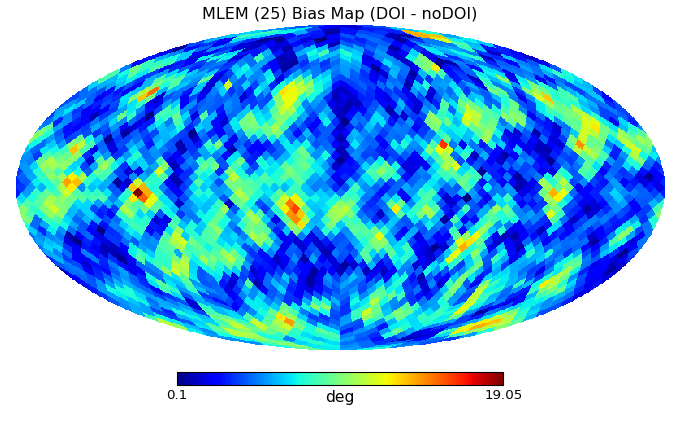

<IPython.core.display.Javascript object>


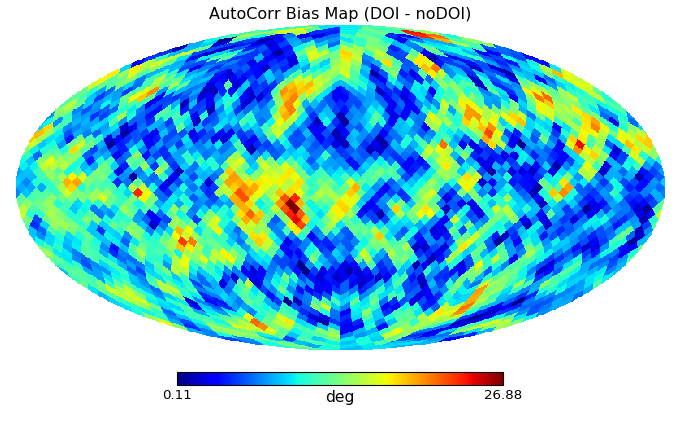

<IPython.core.display.Javascript object>


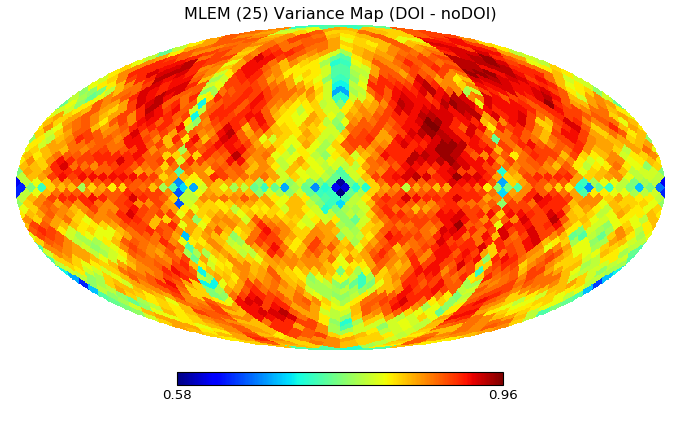

<IPython.core.display.Javascript object>


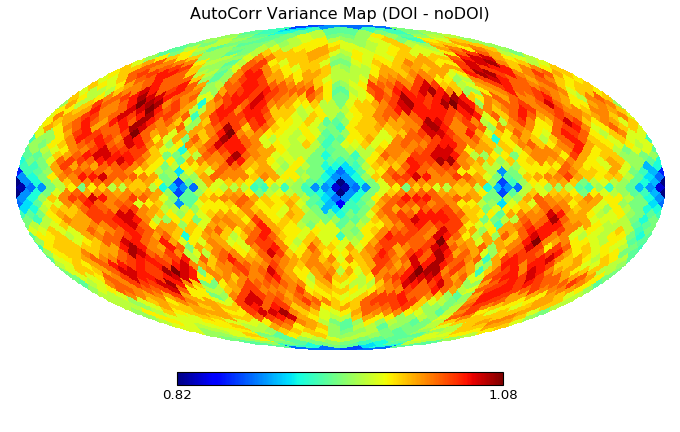

In [43]:
# Plot

bias_mlem  = np.around(bias_mlem, decimals=2)
bias_acorr = np.around(bias_acorr, decimals=2)
var_mlem   = np.around(var_mlem, decimals=2)
var_acorr  = np.around(var_acorr, decimals=2)


hp.mollview(bias_mlem ,unit="deg",title="MLEM (%i) Bias Map (DOI - %s)"     % (itr,choice))
hp.mollview(bias_acorr,unit="deg",title="AutoCorr Bias Map (DOI - %s)" % choice)

hp.mollview(var_mlem ,title="MLEM (%i) Variance Map (DOI - %s)"     % (itr,choice))
hp.mollview(var_acorr,title="AutoCorr Variance Map (DOI - %s)" % choice)

#hp.mollview(std_mlem ,title="MLEM (%i) Std.Dev. Map (DOI - %s)"     % (itr,choice))
#hp.mollview(std_acorr,title="AutoCorr Std.Dev. Map (DOI - %s)" % choice)


### Bias and Variance histograms

<IPython.core.display.Javascript object>


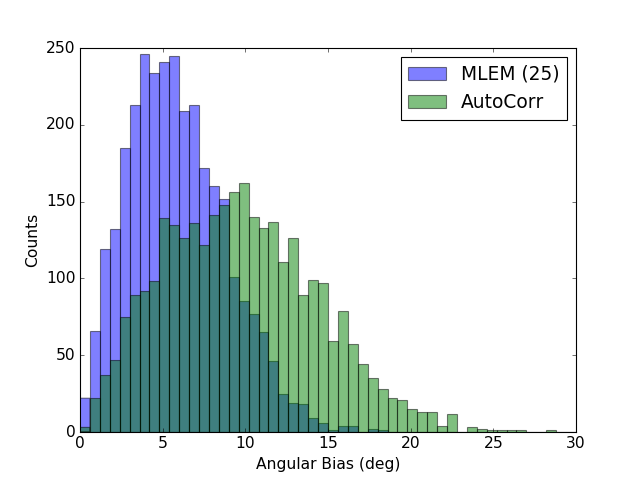

MLEM mean bias =  5.88850260417
AutoCorr mean bias =  9.73202148438

Sum of all MLEM bias =  18089.48
Sum of all AutoCorr bias =  29896.77


<IPython.core.display.Javascript object>


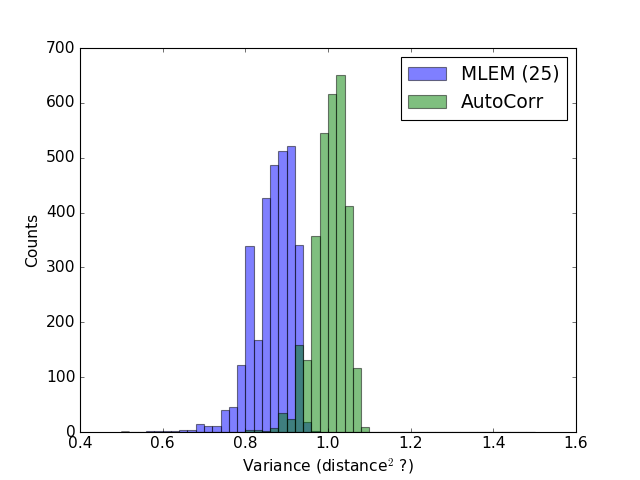

MLEM mean of variance =  0.863063151042
AutoCorr mean of variance =  0.999869791667

Sum of all MLEM variance =  2651.33
Sum of all AutoCorr variance =  3071.6


In [59]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

# Bias
plt.figure()
plt.hist(bias_mlem,bins=50,range=(0,30),alpha=0.5,label="MLEM (%i)" %itr)
plt.hist(bias_acorr,bins=50,range=(0,30),alpha=0.5, label="AutoCorr")
plt.legend(loc='upper right')
plt.ylabel("Counts"); plt.xlabel("Angular Bias (deg)")
plt.show()

print "MLEM mean bias = ",bias_mlem.mean()
print "AutoCorr mean bias = ",bias_acorr.mean()
print
print "Sum of all MLEM bias = ",bias_mlem.sum()
print "Sum of all AutoCorr bias = ",bias_acorr.sum()


# Variance
plt.figure()
plt.hist(var_mlem,bins=50,range=(0.5,1.5),alpha=0.5,label="MLEM (%i)" %itr)
plt.hist(var_acorr,bins=50,range=(0.5,1.5),alpha=0.5, label="AutoCorr")
plt.legend(loc='upper right')
plt.ylabel("Counts"); plt.xlabel("Variance (distance$^2$ ?)")
plt.show()

print "MLEM mean of variance = ",var_mlem.mean()
print "AutoCorr mean of variance = ",var_acorr.mean()
print
print "Sum of all MLEM variance = ",var_mlem.sum()
print "Sum of all AutoCorr variance = ",var_acorr.sum()


# # Std. Dev.
# plt.figure()
# plt.hist(std_mlem,bins=50,range=(0.5,1.5),alpha=0.5,label="MLEM (%i)" %itr)
# plt.hist(std_acorr,bins=50,range=(0.5,1.5),alpha=0.5, label="AutoCorr")
# plt.legend(loc='upper right')
# plt.ylabel("Counts"); plt.xlabel("Std. Dev. (distance ?)")
# plt.show()

# print "MLEM mean of std. dev. = ",std_mlem.mean()
# print "AutoCorr mean of std. dev. = ",std_acorr.mean()
# print
# print "Sum of all MLEM std. dev. = ",std_mlem.sum()
# print "Sum of all AutoCorr std. dev. = ",std_acorr.sum()


### Uniform Sensitivity metric

Produce the normalized sensitivity map for a given mask. Calculate the mean sensitivity. Calculate the deviation from the mean (variance and standard deviation).

<IPython.core.display.Javascript object>


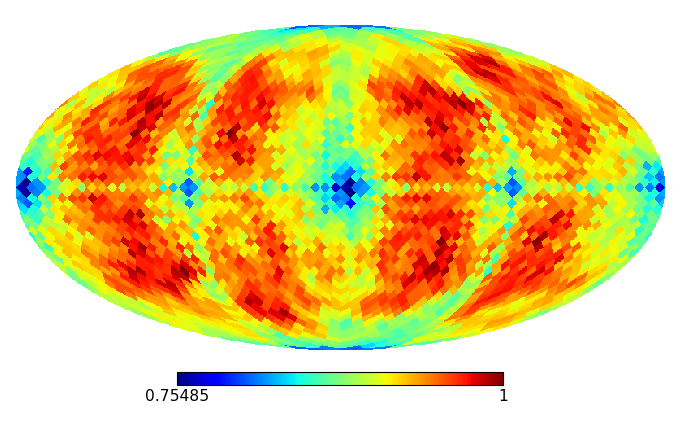

<IPython.core.display.Javascript object>


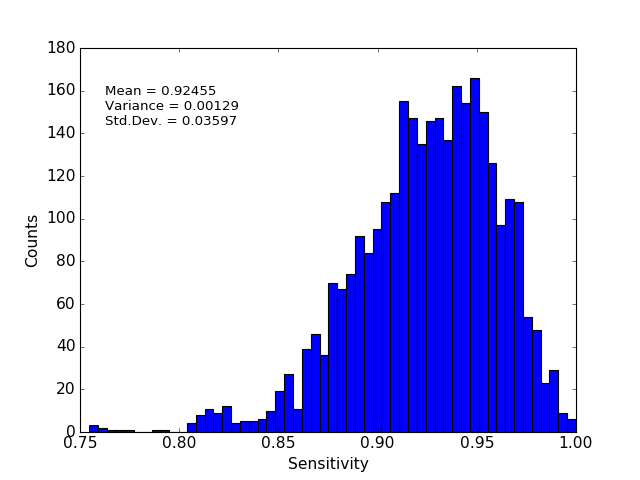

In [51]:
# Calculate the sensitivity
S = np.sum(response_noDOI, axis=0)

# Normalize to the peak sensitivity
S = S/S.max()

S_mean = S.mean()
S_var  = S.var()
S_std  = S.std()

hp.mollview(S, title="")

plt.figure()
plt.hist(S, bins = int(np.sqrt(np.size(S_noDOI))))
plt.xlabel("Sensitivity"); plt.ylabel("Counts")
plt.annotate('Mean = %.5f\nVariance = %.5f\nStd.Dev. = %.5f' % (S_mean, S_var, S_std), (0.05, 0.8), xycoords='axes fraction')
plt.show()


### HEALPix power spectrum

... need to look into what this is actually doing and how we can use this...

<IPython.core.display.Javascript object>


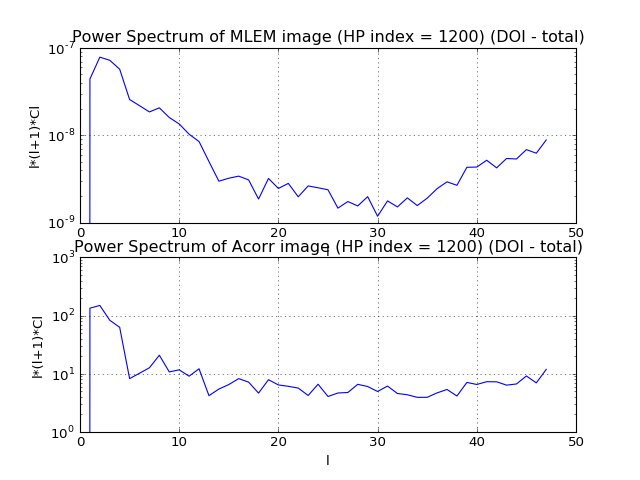

In [96]:
# Grab some image
nside = 16
hpi = 1200

# Choose no DOI, inner, or outer
choice = "none"
#choice = "inner"
#choice = "outer"

if choice == "none":
    _im    = recon
    _acorr = autocorr
    _S     = S
elif choice == "inner":
    _im    = recon_inner
    _acorr = autocorr_inner
    _S     = S_inner
elif choice == "outer":
    _im    = recon_outer
    _acorr = autocorr_outer
    _S     = S_outer

LMAX=3*nside-1
plt.figure()

# Plot the power spectrum of the MLEM image
cl_image1 = hp.anafast(_im[hpi,:], lmax=LMAX)
l_image1 = np.arange(len(cl_image1))
plt.subplot(211)
plt.plot(l_image1, l_image1 * (l_image1+1) * cl_image1 / (2*np.pi))
plt.yscale('log')
plt.xlabel('l'); plt.ylabel('l*(l+1)*Cl'); plt.grid()
plt.title("Power Spectrum of MLEM image (HP index = %i) (DOI - %s)" % (hpi, choice))


# Plot the power spectrum of the AutoCorrelation image
cl_image2 = hp.anafast(_acorr[hpi,:]/_S, lmax=LMAX)
l_image2 = np.arange(len(cl_image2))
plt.subplot(212)
plt.plot(l_image2, l_image2 * (l_image2+1) * cl_image2 / (2*np.pi))
plt.yscale('log')
plt.xlabel('l'); plt.ylabel('l*(l+1)*Cl'); plt.grid()
plt.title("Power Spectrum of Acorr image (HP index = %i) (DOI - %s)" % (hpi, choice) )

'''
# Plot the sensitivity power spectrum
cl_S = hp.anafast(S, lmax=LMAX)
l_S = np.arange(len(cl_S))
plt.subplot(212)
plt.plot(l_S, l_S * (l_S+1) * cl_S / (2*np.pi))
plt.yscale('log')
plt.xlabel('l'); plt.ylabel('l*(l+1)*Cl'); plt.grid()
plt.title("Power Spectrum of the Sensitivity Matrix")
'''

plt.show()

Healpy provides methods to calculate the a_lm's (spherical harmonic coefficients) for a given image. It can then convert those a_lm's back into an image.

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


<IPython.core.display.Javascript object>


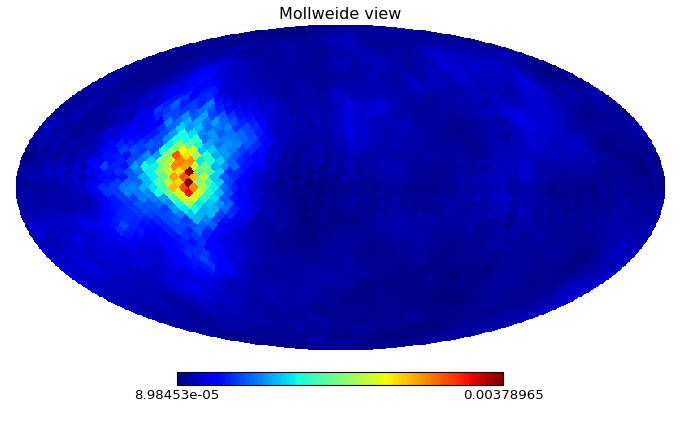

In [63]:
nside = 16

# Can calculate the a_lm's (spherical harmonic coefficients) for any image
alm_image = hp.map2alm(recon[1200,:])

# Can then convert those a_lm's into an image, and then plot it
hp.mollview(hp.alm2map(alm_image, nside))
